In [1]:
import functions as fx
import log_reg_functions as lrf
import loaddata as ld
import NeuralNetwork as nn

import numpy as np
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPRegressor

# D
Creating the Franke function with noise.

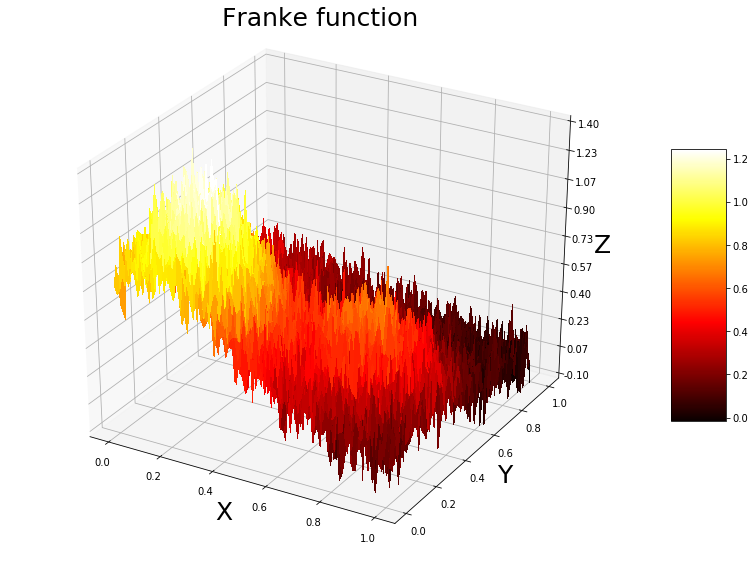

(10000, 21)
(10000, 19)


In [2]:
n=100
x = np.linspace(0,1,n)
y = x
x_mesh, y_mesh  = np.meshgrid(x,y)
noise_level     = 0.1
frank           = fx.FrankeFunction(x_mesh, y_mesh, noise_level)

from matplotlib import cm 
from matplotlib.ticker import LinearLocator, FormatStrFormatter 

from mpl_toolkits.mplot3d import Axes3D 
fig         = plt.figure(figsize=(14,10)) 
ax          = fig.gca(projection='3d')
surf        = ax.plot_surface(x_mesh, y_mesh, frank, cmap='hot', linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40) 
ax.zaxis.set_major_locator(LinearLocator(10)) 
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X', fontsize=25)
ax.set_ylabel('Y', fontsize=25)
ax.set_zlabel('Z', fontsize=25)
plt.title('Franke function', fontsize=25, y=1.05)# Add a color bar which maps values to colors. 
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

frank=frank.ravel()
frank=frank.reshape([len(frank),1])
design=fx.DesignDesign(x,y,5)
print(design.shape)
design=np.delete(design, [0,1], axis=1)
print(design.shape)



In [3]:
epochs=2000
batch_size=int(len(frank)/20)
n_features=design.shape[1]
etavec = np.logspace(-6, -1, 6)
lmbvec = np.logspace(-6, -1, 6)
lmbvec[0]=0
k=5
activation = [lrf.sigmoid, lrf.sigmoid, lrf.relu]
derivative = [lrf.sigmoid_deriv, lrf.sigmoid_deriv, lrf.relu_deriv]



y_folds, x_folds = lrf.k_fold_reshaper(k,frank,design,shuffle=True)
test_loss = np.zeros((len(etavec), len(lmbvec)))
test_r2 = np.zeros((len(etavec), len(lmbvec)))
for i, etas in enumerate(etavec):
    for j, lmb in enumerate(lmbvec):
        
        for kf in range(k):
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            
            np.random.seed(2019)
            neural_net = nn.ANN(lmb=lmb, bias=0, eta=etas,early_stop_tol = 0,\
                                early_stop_nochange=2000, mode = 'regression', regularization = 'l1')            
            neural_net.add_layers(n_features=[n_features,20,10], n_neurons = [20,10,1] , n_layers=3)

            neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=False)

            pred = neural_net.feed_out(xtest, activation)
            test_loss[i,j] +=  fx.MSE(pred.ravel(),ytest.T)
            test_r2[i,j] +=  fx.R2Score(pred.ravel(),ytest.T)
            
        print('test loss for', '\u03B7 =', etas, '&', '\u03BB =', lmb, '=', test_loss [i,j]/k)

test_loss = test_loss/k
test_r2 = test_r2/k

KeyboardInterrupt: 

In [ ]:
yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 12))
sns.heatmap(test_loss, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels)
#ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$", fontsize=20)
ax.set_xlabel("$\lambda$", fontsize=20)
tmp = np.arange(len(etavec))+0.5
tmp[0] = 0
tmp[-1]+=0.5
ax.set_yticks(tmp)
tmp = np.arange(len(lmbvec)) + 0.5
ax.set_xticks(tmp)
plt.show()

In [ ]:
yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 12))
sns.heatmap(test_r2, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels, vmin=0, vmax=1)
#ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$", fontsize=20)
ax.set_xlabel("$\lambda$", fontsize=20)
tmp = np.arange(len(etavec))+0.5
tmp[0] = 0
tmp[-1]+=0.5
ax.set_yticks(tmp)
tmp = np.arange(len(lmbvec)) + 0.5
ax.set_xticks(tmp)
plt.show()

test loss for η = 0.001 & λ = 0.0 = 0.04710652513975534


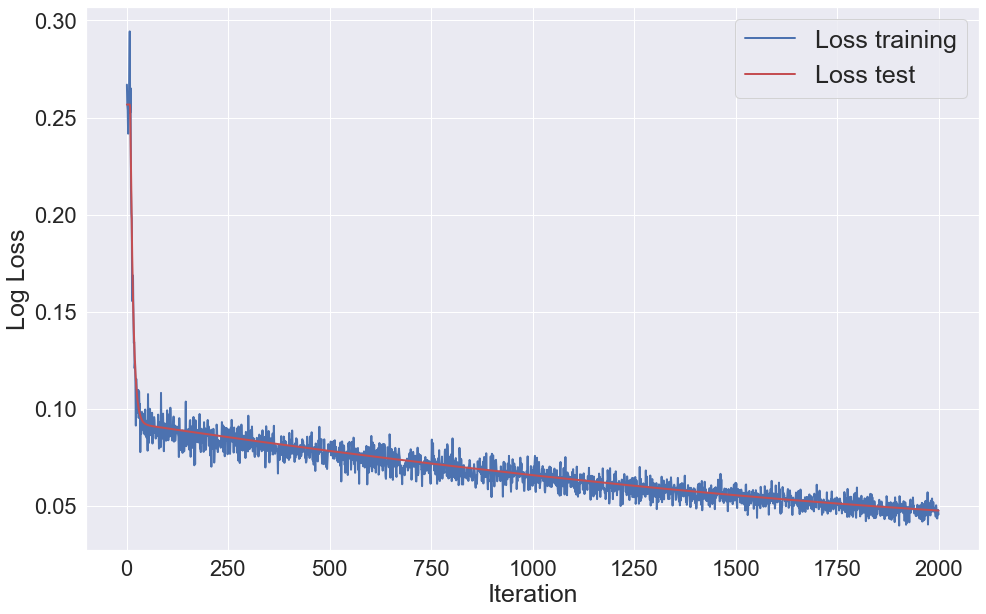

test loss for η = 0.012 & λ = 0.0 = 0.026949119348144656


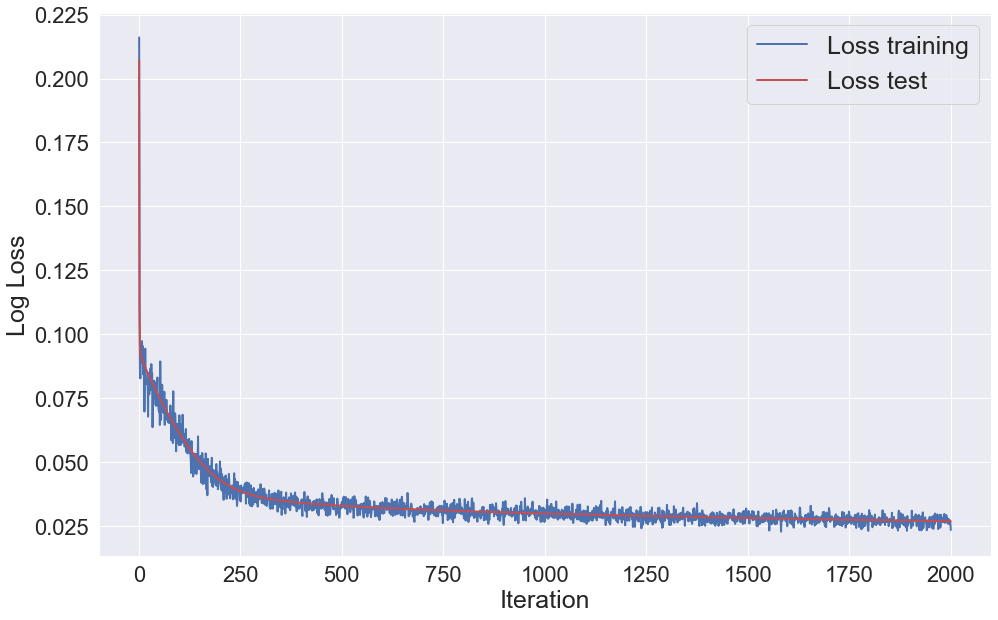

test loss for η = 0.023000000000000003 & λ = 0.0 = 0.023288497939049094


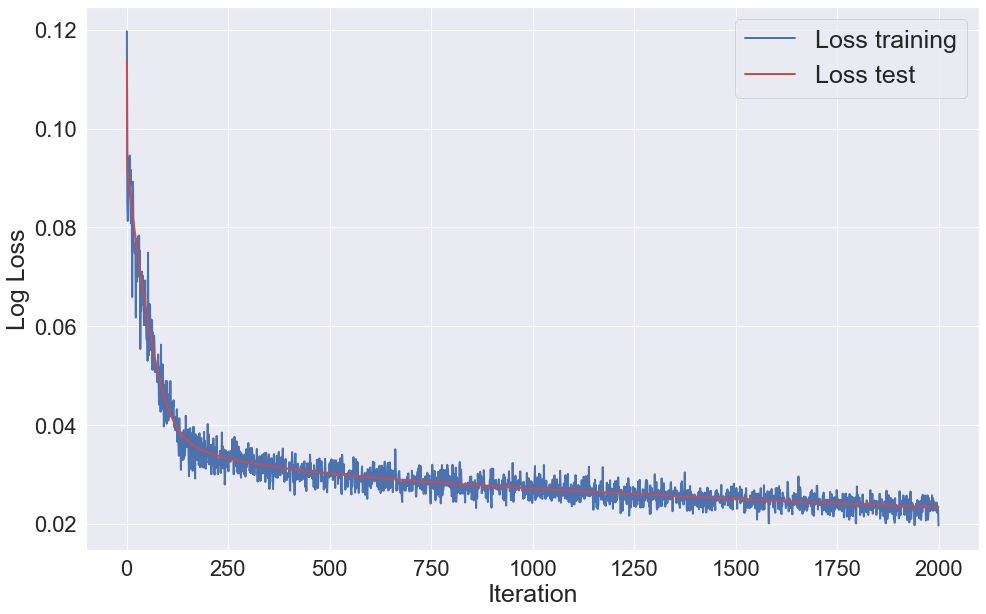

test loss for η = 0.034 & λ = 0.0 = 0.021029394228835804


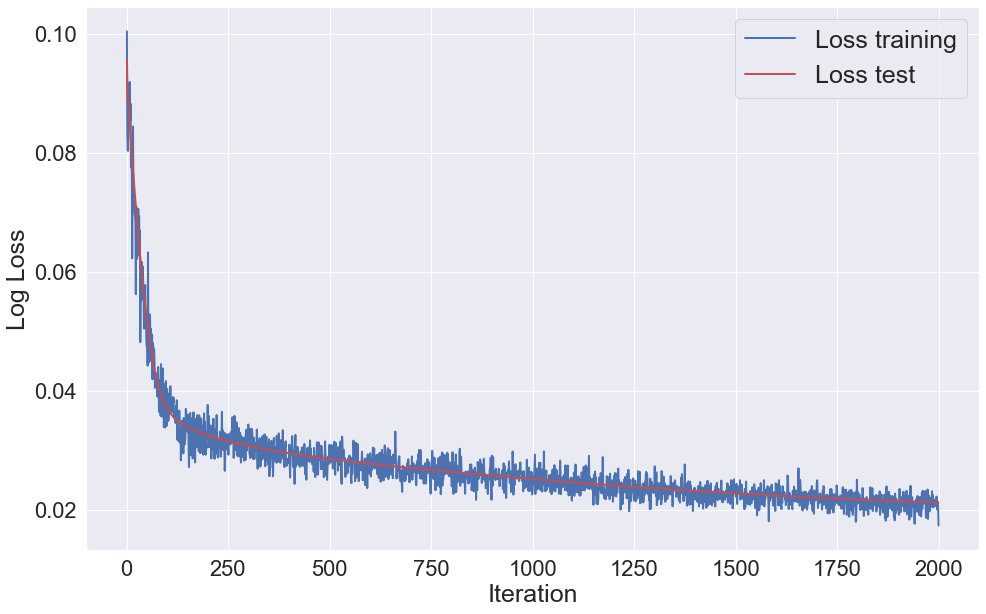

test loss for η = 0.045000000000000005 & λ = 0.0 = 0.019733059008520768


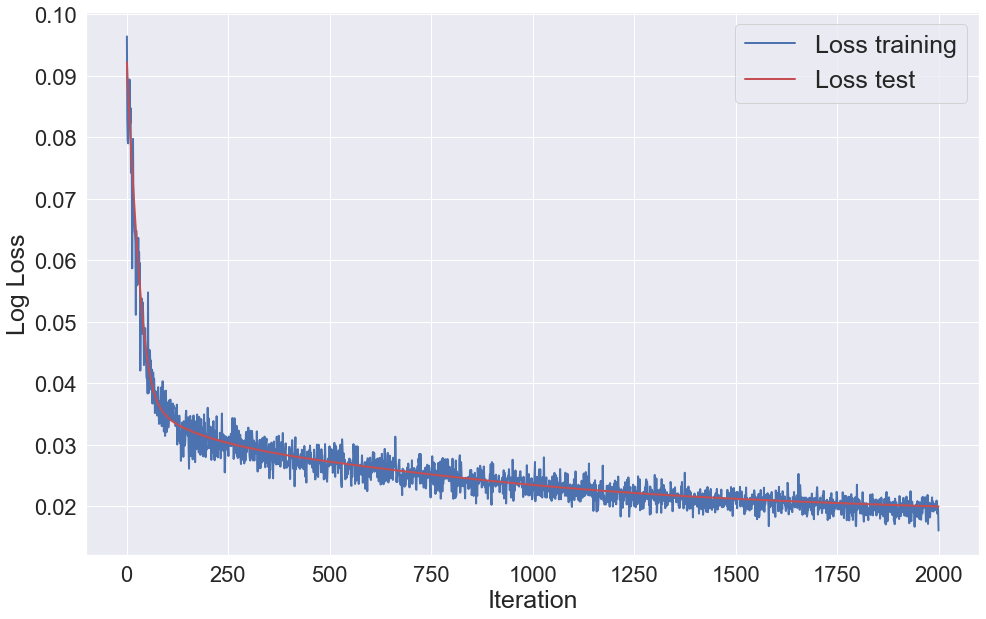

test loss for η = 0.05600000000000001 & λ = 0.0 = 0.018766657991220993


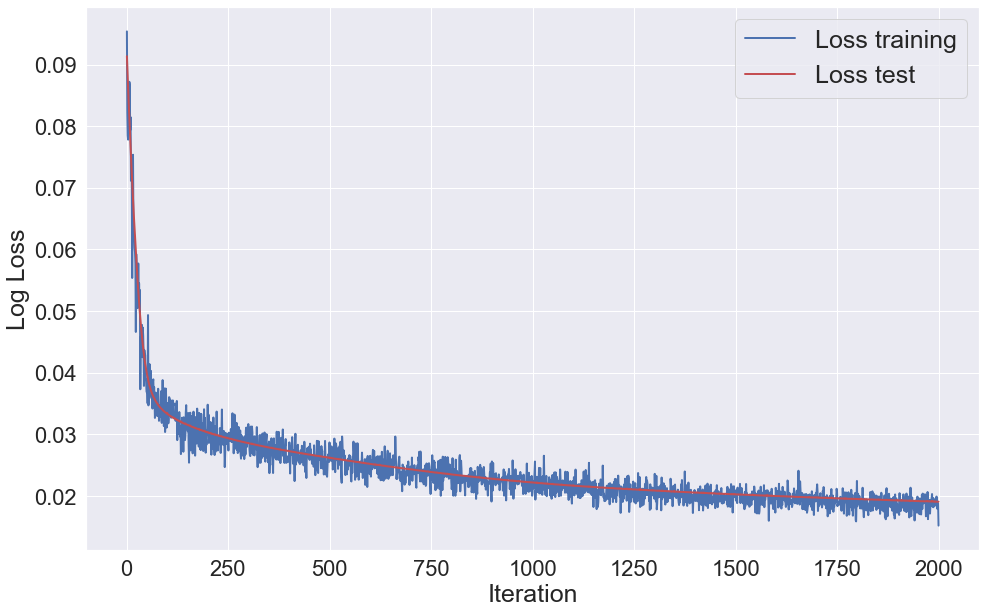

In [ ]:
epochs=2000
batch_size=int(len(frank)/20)
n_features=design.shape[1]
etavec = np.linspace(0.001, 0.1, 10)
lmbvec = np.logspace(-6, -5, 1)
lmbvec[0]=0
k=5
activation = [lrf.sigmoid, lrf.sigmoid, lrf.relu]
derivative = [lrf.sigmoid_deriv, lrf.sigmoid_deriv, lrf.relu_deriv]



y_folds, x_folds = lrf.k_fold_reshaper(k,frank,design,shuffle=True)
test_loss = np.zeros((len(etavec), len(lmbvec)))
test_r2 = np.zeros((len(etavec), len(lmbvec)))
for i, etas in enumerate(etavec):
    for j, lmb in enumerate(lmbvec):
        
        for kf in range(k):
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            
            np.random.seed(2019)
            neural_net = nn.ANN(lmb=lmb, bias=0, eta=etas,early_stop_tol = 0,\
                                early_stop_nochange=2000, mode = 'regression', regularization = 'l1')            
            neural_net.add_layers(n_features=[n_features,20,10], n_neurons = [20,10,1] , n_layers=3)

            neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=False)

            pred = neural_net.feed_out(xtest, activation)
            test_loss[i,j] +=  fx.MSE(pred.ravel(),ytest.T)
            test_r2[i,j] +=  fx.R2Score(pred.ravel(),ytest.T)
            
        print('test loss for', '\u03B7 =', etas, '&', '\u03BB =', lmb, '=', test_loss [i,j]/k)
        cost_test, cost_train = neural_net.costs()

        sns.set(font_scale=2)
        plt.figure(figsize=([16,10]))
        axis = np.arange(len(cost_train))+1
        plt.plot(axis, cost_train, 'b', label='Loss training', linewidth=2)
        plt.plot(axis, cost_test, 'r', label='Loss test', linewidth=2)
        plt.legend(fontsize=25)
        plt.ylabel('MSE',fontsize=25)
        plt.xlabel('Iteration',fontsize=25)
        plt.show()

test_loss = test_loss/k
test_r2 = test_r2/k

In [ ]:
best_eta_index, best_lmb_index = np.where(test_loss == np.min(test_loss))
best_eta,best_lmb = etavec[best_eta_index], lmbvec[best_lmb_index] 
print('eta=',best_eta)
print('lmb=',best_lmb)

In [6]:
k=5
y_folds, x_folds = lrf.k_fold_reshaper(k,frank,design,shuffle=True)
test_loss_best = 0
test_r2_best = 0
n_features=design.shape[1]
batch_size=int(len(frank)/20)

best_eta=0.1
best_lmb=0.0
activation = [lrf.sigmoid, lrf.sigmoid, lrf.nooutact]
derivative = [lrf.sigmoid_deriv, lrf.sigmoid_deriv, lrf.nooutact_deriv]
epochs= 2000
for kf in range(1):
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            
            np.random.seed(2019)
            neural_net = nn.ANN(lmb=best_lmb, bias=0, eta=best_eta,early_stop_tol = 0,\
                                early_stop_nochange=1500, mode = 'regression', regularization = 'l1')            
            neural_net.add_layers(n_features=[n_features,45,30], n_neurons = [45,30,1] , n_layers=3)

            neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=True)

            pred = neural_net.feed_out(xtest, activation)
            test_loss_best +=  fx.MSE(ytest.ravel(),pred.ravel())
            test_r2_best +=  fx.R2Score(ytest.ravel(),pred.ravel())

test_loss_best /= 1
test_r2_best /= 1
cost_test, cost_train = neural_net.costs()
print(test_r2_best, 'r2 score')
print(test_loss_best, 'MSE')
            

Epoch 1 loss 0.07644719743108935
Epoch 2 loss 0.07075804813949194
Epoch 3 loss 0.06668198895115819
Epoch 4 loss 0.0623790042678875
Epoch 5 loss 0.05858064540313868
Epoch 6 loss 0.05530235594491823
Epoch 7 loss 0.05268223466802025
Epoch 8 loss 0.051376513851457944
Epoch 9 loss 0.048463290579274634
Epoch 10 loss 0.04685094572424881
Epoch 11 loss 0.045225995105236116
Epoch 12 loss 0.04394719012501546
Epoch 13 loss 0.042938718641100396
Epoch 14 loss 0.04181932667426664
Epoch 15 loss 0.04098830059183041
Epoch 16 loss 0.04024928952117312
Epoch 17 loss 0.03967928111824844
Epoch 18 loss 0.03899674688137235
Epoch 19 loss 0.03850624352822656
Epoch 20 loss 0.037994744970104403
Epoch 21 loss 0.03757036210868355
Epoch 22 loss 0.037226894594747935
Epoch 23 loss 0.03683559564492908
Epoch 24 loss 0.03647493347394584
Epoch 25 loss 0.0361189236705773
Epoch 26 loss 0.03578144659472167
Epoch 27 loss 0.03565371129783648
Epoch 28 loss 0.03518576837310739
Epoch 29 loss 0.034928286773680414
Epoch 30 loss 0.03

Epoch 236 loss 0.02371145169191514
Epoch 237 loss 0.023702014862085726
Epoch 238 loss 0.023676990266539265
Epoch 239 loss 0.023673635327552952
Epoch 240 loss 0.023658767245338816
Epoch 241 loss 0.023622709650758668
Epoch 242 loss 0.0236469429657076
Epoch 243 loss 0.023701162268239123
Epoch 244 loss 0.023592982799841806
Epoch 245 loss 0.023795907236356224
Epoch 246 loss 0.02359182704605929
Epoch 247 loss 0.023791800863881395
Epoch 248 loss 0.023503534432048945
Epoch 249 loss 0.023483530409071536
Epoch 250 loss 0.02351899840807976
Epoch 251 loss 0.02351606782129469
Epoch 252 loss 0.02344872836018049
Epoch 253 loss 0.02343952358188173
Epoch 254 loss 0.023499201351601183
Epoch 255 loss 0.023419822665856415
Epoch 256 loss 0.02345180833228264
Epoch 257 loss 0.023453343164700245
Epoch 258 loss 0.023372306108262946
Epoch 259 loss 0.02331843883395017
Epoch 260 loss 0.02330289883051694
Epoch 261 loss 0.023351016161997442
Epoch 262 loss 0.02326655431283702
Epoch 263 loss 0.023263738637025792
Epoc

Epoch 469 loss 0.02095429381079066
Epoch 470 loss 0.02099080640938105
Epoch 471 loss 0.020937296766560812
Epoch 472 loss 0.020960109502474355
Epoch 473 loss 0.021041462492360476
Epoch 474 loss 0.020895029328964143
Epoch 475 loss 0.020883698079348888
Epoch 476 loss 0.020888296290825736
Epoch 477 loss 0.020887781858121453
Epoch 478 loss 0.02089817018867113
Epoch 479 loss 0.020960288439009454
Epoch 480 loss 0.020865529094179016
Epoch 481 loss 0.02086709736706755
Epoch 482 loss 0.020854505595063955
Epoch 483 loss 0.02090407611976591
Epoch 484 loss 0.02083144288096338
Epoch 485 loss 0.020834235283159083
Epoch 486 loss 0.02079273975158754
Epoch 487 loss 0.0207820783644484
Epoch 488 loss 0.02082344661708832
Epoch 489 loss 0.02086851091983824
Epoch 490 loss 0.020774477979146368
Epoch 491 loss 0.020776789837906266
Epoch 492 loss 0.021063127685032237
Epoch 493 loss 0.02074626906265405
Epoch 494 loss 0.02075718821698144
Epoch 495 loss 0.020800102203894826
Epoch 496 loss 0.020801818362704005
Epoch

Epoch 700 loss 0.01969053688314011
Epoch 701 loss 0.01986710573251004
Epoch 702 loss 0.019602074536092466
Epoch 703 loss 0.019706337262152124
Epoch 704 loss 0.019629935477726932
Epoch 705 loss 0.019677290809452422
Epoch 706 loss 0.019614605333286
Epoch 707 loss 0.019726559214772007
Epoch 708 loss 0.019598324408720866
Epoch 709 loss 0.01956209750835177
Epoch 710 loss 0.019554906896101492
Epoch 711 loss 0.019594027803179682
Epoch 712 loss 0.01955322425034619
Epoch 713 loss 0.01954095962920386
Epoch 714 loss 0.019558880683901932
Epoch 715 loss 0.01970450321459208
Epoch 716 loss 0.019527704001731504
Epoch 717 loss 0.019524321572016386
Epoch 718 loss 0.019633406979331722
Epoch 719 loss 0.01955169822503138
Epoch 720 loss 0.019515138046366124
Epoch 721 loss 0.019519362175780222
Epoch 722 loss 0.019514627010304448
Epoch 723 loss 0.019557352457388412
Epoch 724 loss 0.019550843720757792
Epoch 725 loss 0.019487943140886387
Epoch 726 loss 0.019649779560015963
Epoch 727 loss 0.019477940672930287
Ep

Epoch 932 loss 0.0187787227875297
Epoch 933 loss 0.01880572970817186
Epoch 934 loss 0.018785912805000467
Epoch 935 loss 0.01874754894648665
Epoch 936 loss 0.018766120045691823
Epoch 937 loss 0.01877868397734674
Epoch 938 loss 0.018740213380213637
Epoch 939 loss 0.018819043584838203
Epoch 940 loss 0.018745451973553814
Epoch 941 loss 0.01873502593321169
Epoch 942 loss 0.0187224191678542
Epoch 943 loss 0.018720714278010198
Epoch 944 loss 0.01874171069151794
Epoch 945 loss 0.018725926168387756
Epoch 946 loss 0.018918707038267313
Epoch 947 loss 0.018749070067488216
Epoch 948 loss 0.018701632191442413
Epoch 949 loss 0.01881942993620409
Epoch 950 loss 0.0186963416692268
Epoch 951 loss 0.018706445236001075
Epoch 952 loss 0.018755972656442032
Epoch 953 loss 0.018898872540338646
Epoch 954 loss 0.018740602378997776
Epoch 955 loss 0.018703633908405265
Epoch 956 loss 0.0186793563366408
Epoch 957 loss 0.01867618933040836
Epoch 958 loss 0.018696153607391863
Epoch 959 loss 0.018679728696774353
Epoch 9

Epoch 1160 loss 0.018135915808037438
Epoch 1161 loss 0.01811806855580461
Epoch 1162 loss 0.018134232890192337
Epoch 1163 loss 0.0182394807672731
Epoch 1164 loss 0.01810510681748383
Epoch 1165 loss 0.01809606591681797
Epoch 1166 loss 0.018138725443762292
Epoch 1167 loss 0.01809155923705006
Epoch 1168 loss 0.018860279037321973
Epoch 1169 loss 0.01823368961532168
Epoch 1170 loss 0.01816247405325337
Epoch 1171 loss 0.01813490333054125
Epoch 1172 loss 0.018117758044836778
Epoch 1173 loss 0.018198818390444387
Epoch 1174 loss 0.018147702060029438
Epoch 1175 loss 0.018083207636866567
Epoch 1176 loss 0.018071909542075878
Epoch 1177 loss 0.01809490055951502
Epoch 1178 loss 0.018222681752804122
Epoch 1179 loss 0.018210635813020275
Epoch 1180 loss 0.018121799903405574
Epoch 1181 loss 0.018097361817948462
Epoch 1182 loss 0.01805907644754936
Epoch 1183 loss 0.018160959629201494
Epoch 1184 loss 0.018182322920655924
Epoch 1185 loss 0.018052792946606076
Epoch 1186 loss 0.018037430156812615
Epoch 1187 l

Epoch 1384 loss 0.01760351727808321
Epoch 1385 loss 0.017578529950902037
Epoch 1386 loss 0.01761549870715686
Epoch 1387 loss 0.017752121881856254
Epoch 1388 loss 0.017583852824728918
Epoch 1389 loss 0.017626060567619947
Epoch 1390 loss 0.017586965920108426
Epoch 1391 loss 0.017712941879042887
Epoch 1392 loss 0.017574499130820834
Epoch 1393 loss 0.017701470628083218
Epoch 1394 loss 0.01774912417340938
Epoch 1395 loss 0.017569929821451044
Epoch 1396 loss 0.017738442982272597
Epoch 1397 loss 0.017600678080561656
Epoch 1398 loss 0.017565065132018994
Epoch 1399 loss 0.01767997361820512
Epoch 1400 loss 0.017574891002119224
Epoch 1401 loss 0.017599578254659947
Epoch 1402 loss 0.017585950174263773
Epoch 1403 loss 0.017553574935272195
Epoch 1404 loss 0.017634525980678675
Epoch 1405 loss 0.017527661065070154
Epoch 1406 loss 0.017530388676857026
Epoch 1407 loss 0.01754280479388592
Epoch 1408 loss 0.017582466224706033
Epoch 1409 loss 0.017526635172066707
Epoch 1410 loss 0.01751743688183319
Epoch 1

Epoch 1609 loss 0.017112171976037253
Epoch 1610 loss 0.01711094167801009
Epoch 1611 loss 0.017134230412848703
Epoch 1612 loss 0.017117444121252025
Epoch 1613 loss 0.017163167802240465
Epoch 1614 loss 0.017110900873501193
Epoch 1615 loss 0.017143086254901938
Epoch 1616 loss 0.017125697564136354
Epoch 1617 loss 0.017199070999196656
Epoch 1618 loss 0.017448821885701207
Epoch 1619 loss 0.01709268434013901
Epoch 1620 loss 0.017103597966850414
Epoch 1621 loss 0.017091136729967857
Epoch 1622 loss 0.0171004096244639
Epoch 1623 loss 0.017100092857038417
Epoch 1624 loss 0.017223623709393805
Epoch 1625 loss 0.017087026843969007
Epoch 1626 loss 0.01708707962447172
Epoch 1627 loss 0.017215345105174765
Epoch 1628 loss 0.017135775514706075
Epoch 1629 loss 0.01710539171115452
Epoch 1630 loss 0.01714796566959326
Epoch 1631 loss 0.017067166097558213
Epoch 1632 loss 0.017064473262398464
Epoch 1633 loss 0.01735646365218304
Epoch 1634 loss 0.017273221584281025
Epoch 1635 loss 0.01715877480611355
Epoch 1636

Epoch 1834 loss 0.01698068326315679
Epoch 1835 loss 0.016721975919904958
Epoch 1836 loss 0.016697770719261703
Epoch 1837 loss 0.016690926354437554
Epoch 1838 loss 0.016831154588862116
Epoch 1839 loss 0.01671574123506016
Epoch 1840 loss 0.01671763835105873
Epoch 1841 loss 0.016735685091377017
Epoch 1842 loss 0.01697209305614218
Epoch 1843 loss 0.0167527774196218
Epoch 1844 loss 0.016816913898589633
Epoch 1845 loss 0.016719286592947084
Epoch 1846 loss 0.016670745382422806
Epoch 1847 loss 0.01668925515473886
Epoch 1848 loss 0.016934398288265814
Epoch 1849 loss 0.016672057921978015
Epoch 1850 loss 0.016840233879364133
Epoch 1851 loss 0.016711627199948228
Epoch 1852 loss 0.01681483094524367
Epoch 1853 loss 0.01666763144822991
Epoch 1854 loss 0.016750391770672873
Epoch 1855 loss 0.017081260649356337
Epoch 1856 loss 0.016680526517261464
Epoch 1857 loss 0.016669660548376528
Epoch 1858 loss 0.016660439509477685
Epoch 1859 loss 0.01666501411673203
Epoch 1860 loss 0.016740373927167183
Epoch 1861 

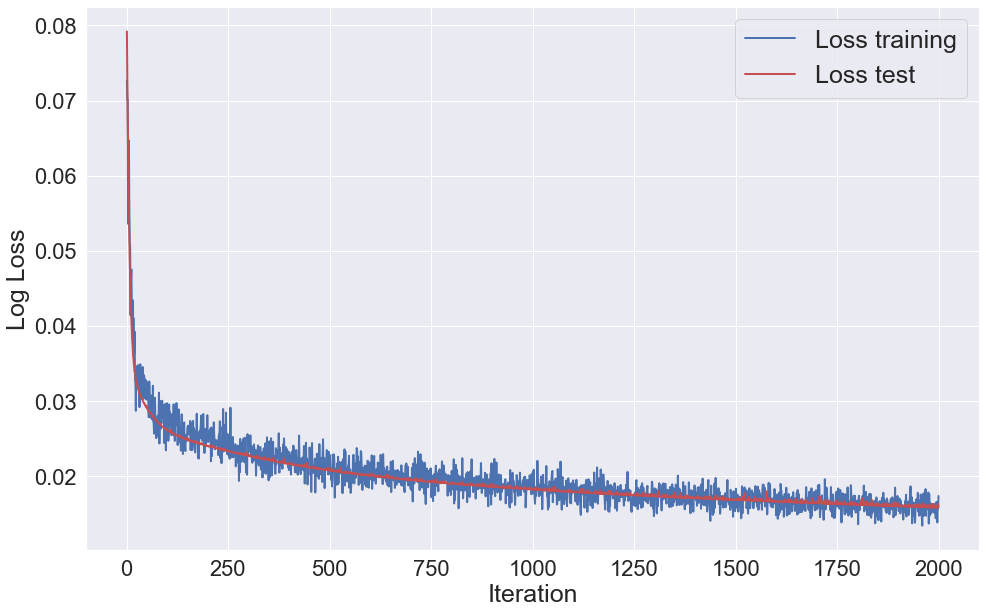

In [27]:
cost_test, cost_train = neural_net.costs()

sns.set(font_scale=2)
plt.figure(figsize=([16,10]))
axis = np.arange(len(cost_train))+1
plt.plot(axis, cost_train, 'b', label='Loss training', linewidth=2)
plt.plot(axis, cost_test, 'r', label='Loss test', linewidth=2)
plt.legend(fontsize=25)
plt.ylabel('MSE',fontsize=25)
plt.xlabel('Epoch',fontsize=25)
plt.show()

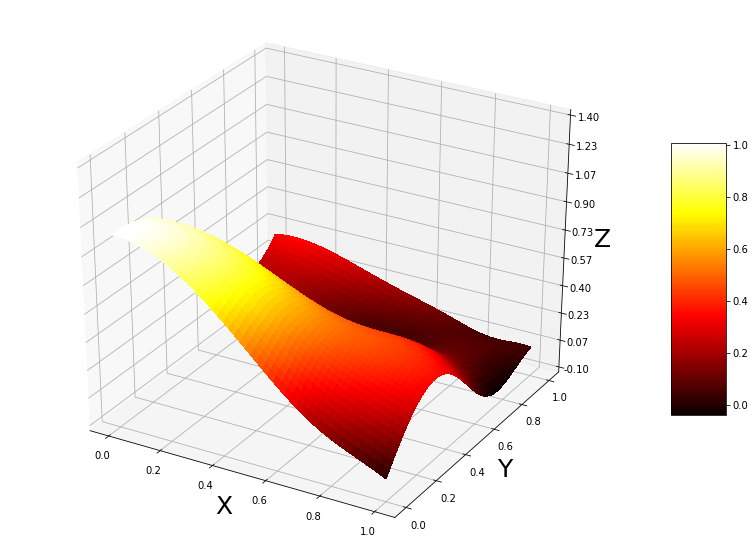

0.8217335682240023


In [7]:
pred = neural_net.feed_out(design, activation)


fig         = plt.figure(figsize=(14,10)) 
ax          = fig.gca(projection='3d')
surf        = ax.plot_surface(x_mesh, y_mesh, pred.reshape([n,n]), cmap='hot', linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40) 
ax.zaxis.set_major_locator(LinearLocator(10)) 
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X', fontsize=25)
ax.set_ylabel('Y', fontsize=25)
ax.set_zlabel('Z', fontsize=25)
#plt.title('Franke function', fontsize=25, y=1.05)# Add a color bar which maps values to colors. 
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


print(fx.R2Score(frank.ravel(),pred.ravel()))

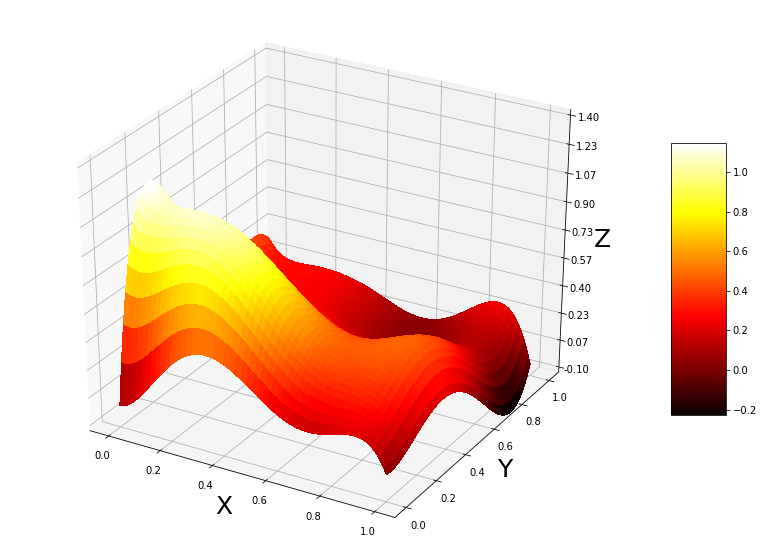

0.7568836002640109

In [8]:
beta, pred = fx.OridinaryLeastSquares(design, frank, design)

fig         = plt.figure(figsize=(14,10)) 
ax          = fig.gca(projection='3d')
surf        = ax.plot_surface(x_mesh, y_mesh, pred.reshape([n,n]), cmap='hot', linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40) 
ax.zaxis.set_major_locator(LinearLocator(10)) 
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X', fontsize=25)
ax.set_ylabel('Y', fontsize=25)
ax.set_zlabel('Z', fontsize=25)
#plt.title('Franke function', fontsize=25, y=1.05)# Add a color bar which maps values to colors. 
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

fx.R2Score(ytest,xtest@beta)



In [ ]:
design=fx.DesignDesign(x,y,8)
design=np.delete(design, [0,1], axis=1)

X_train = design
Y_train = frank.ravel()

n_hidden_neurons = (45,30)
epochs = 1000
eta_vals = np.logspace(-2, -1, 2)
lmbd_vals = np.logspace(-5, 1, 7)
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
sns.set()
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, Y_train)
        DNN_scikit[i][j] = dnn
        train_accuracy[i][j] = dnn.score(X_train, Y_train)
        print(train_accuracy[i][j])
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

In [ ]:
best_eta_index, best_lmb_index = np.where(train_accuracy == np.max(train_accuracy))
best_eta,best_lmb = eta_vals[best_eta_index], lmbd_vals[best_lmb_index] 
print(best_eta, 'eta')
print(best_lmb, 'lmb') 


dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=best_lmb, learning_rate_init=best_eta, max_iter=epochs*100)
dnn.fit(X_train, Y_train)
DNN_scikit = dnn
train_accuracy = dnn.score(X_train, Y_train)
print(train_accuracy)

In [ ]:
pred = dnn.predict(X_train)

fig         = plt.figure(figsize=(14,10)) 
ax          = fig.gca(projection='3d')
surf        = ax.plot_surface(x_mesh, y_mesh, pred.reshape([n,n]), cmap='hot', linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40) 
ax.zaxis.set_major_locator(LinearLocator(10)) 
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X', fontsize=25)
ax.set_ylabel('Y', fontsize=25)
ax.set_zlabel('Z', fontsize=25)
#plt.title('Franke function', fontsize=25, y=1.05)# Add a color bar which maps values to colors. 
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


print(fx.R2Score(frank.ravel(),pred))